# Demonstration for RED-diff

Paper  https://arxiv.org/abs/2305.04391.

Solving a (nonlinear) inverse problem: 
$$
y=f(x_{0})+v,\quad v\sim{\mathcal{N}}(0,\sigma_{v}^{2}I)
$$


loc("mps_not_equal"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":253:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W65536 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.not_equal_zero' op Invalid configuration for the following reasons: Tensor dimensions N1D1C1H1W65536 are not within supported range, N[1-65536]D[1-16384]C[1-65536]H[1-16384]W[1-16384].


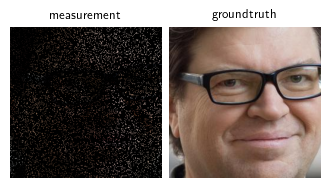

In [1]:
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from tqdm import tqdm  # to visualize progress

# device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
# device = "mps" # running on Apple Silicon
device = "mps"

# url = get_image_url("butterfly.png")
url = "https://engineering.nyu.edu/sites/default/files/styles/square_large_620_1_5x/public/2018-06/yann-lecun.jpg?h=65172a10&itok=1HNIDUCy"

x_true = load_url_image(url=url, img_size=256).to(device)
x = x_true.clone()

sigma = 12.75 / 255.0  # noise level

physics = dinv.physics.Inpainting(
    tensor_size=(3, x.shape[-2], x.shape[-1]),
    mask=0.1,
    pixelwise=True,
    device=device,
)

y = physics(x_true)

imgs = [y, x_true]
plot(
    imgs,
    titles=["measurement", "groundtruth"],
)

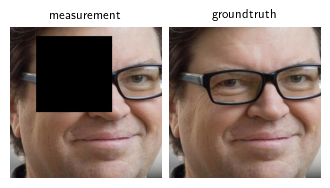

In [2]:
#@title Custom Physics
def random_sq_bbox(img, mask_shape, image_size=256, margin=(16, 16)):
    """Generate a random sqaure mask for inpainting
    """
    B, C, H, W = img.shape
    h, w = mask_shape
    margin_height, margin_width = margin
    maxt = image_size - margin_height - h
    maxl = image_size - margin_width - w

    # bb
    t = np.random.randint(margin_height, maxt)
    l = np.random.randint(margin_width, maxl)

    # make mask
    mask = torch.ones([B, C, H, W], device=img.device)
    mask[..., t:t+h, l:l+w] = 0

    return mask, t, t+h, l, l+w

h, w = x.shape[-1] // 2, x.shape[-1] // 2
single_mask = random_sq_bbox(x, 
                             mask_shape=(h, w),
                             image_size=x.shape[-1],
                             margin=(8,8))[0]

def _custom_physics(x, mask=single_mask):
    return mask * x

from functools import partial
custom_physics = partial(_custom_physics, mask=single_mask)
y = custom_physics(x_true)


imgs = [y, x_true]
plot(
    imgs,
    titles=["measurement", "groundtruth"],
)

y = 2*y - 1

The forward diffusion process is:
$$
d x=-{\frac{\beta(t)}{2}}x d t+{\sqrt{\beta(t)}}d w,
$$

with reverse SDE:
$$
d x=\left[-\frac{\beta(t)}{2}x-\beta(t)\nabla_{x_{t}}\log p_{t}(x_{t})\right]d t+\sqrt{\beta(t)}d\bar{w},
$$

The prior is $p(x)$ and we aim to sample from the posterior $p(x|y)$ by modifying the score in the reverse SDE:  

$$
d x=\left[-\frac{\beta(t)}{2}x-\beta(t)(\nabla_{x_{t}}\log p_{t}(x_{t})+\nabla_{x_{t}}\log p_{t}(y|x_{t}))\right]d t+\sqrt{\beta(t)}d\bar{w},
$$

The main difficulty is to get a tractable form of $p(y \mid x_t)$. 

## A variational approach

In [3]:
model = dinv.models.DiffUNet(large_model= False).to(device)

In [4]:
def get_timesteps(start_step, 
                  end_step, 
                  num_steps = 1000):
    """Returns time steps."""
    skip = (start_step - end_step) // num_steps
    ts = list(range(end_step, start_step, skip))
    return ts

In [11]:
def get_alpha_beta(
    beta_start, 
    beta_end, 
    beta_schedule="linear", 
    num_steps=1000, 
    device="cpu"
):
    """Returns beta values and alpha values."""
    if beta_schedule == "linear":
        betas = np.linspace(beta_start, 
                            beta_end, 
                            num_steps, 
                            dtype=np.float32)
    else:
        raise NotImplementedError(f"beta_schedule {beta_schedule} not implemented.")

    _beta_vals = torch.from_numpy(betas).to(device)
    beta_vals = (
        torch.cat([torch.zeros(1).to(device), _beta_vals], dim=0).to(device).float()
    )
    alpha_vals = (1 - beta_vals).cumprod(dim=0).to(device).float()

    return alpha_vals, beta_vals

In [8]:
def red_diff(num_steps,
             x_true,
             y0,
             device,
             model,
             physics,
             save_evolutions=False,
             **kwargs):
    """
    Returns true x0 from observed y0.
    """
    x = y0.clone().detach().requires_grad_(True)
    # x = physics(x_true)

    n = x.shape[0]
    eta = kwargs.get("eta", 0.0) # the eta in DDIM
    grad_term_weight = kwargs.get("grad_term_weight", 1.0)
    obs_weight = kwargs.get("obs_weight", 1.0)

    ts = get_timesteps(num_steps, 0, num_steps)
    ss = [-1] + list(ts[:-1]) # time with -1

    mu_s = x.cpu()
    x0_pred_s = x.cpu()

    # mu is the mean of the variational distribution and needs to be optimized
    mu = torch.autograd.Variable(x, requires_grad=True)
    optimizer = torch.optim.Adam([mu],
                                 lr=kwargs.get("lr", 0.1),
                                 betas=(0.9, 0.99),
                                 weight_decay=0.0)

    # loading alpha_t and beta_t
    alpha_vals, beta_vals = get_alpha_beta(
        beta_start=0.0001,
        beta_end=0.02,
        beta_schedule="linear",
        num_steps=num_steps,
        device="cpu"
    )
    
    alpha_vals = alpha_vals.to(device)

    for ti, si in tqdm(zip(reversed(ts), reversed(ss)),
                       total=len(ts),
                       colour="green"):
        # print(ti)
        t = torch.ones(n).to(x.device).long() * ti
        s = torch.ones(n).to(x.device).long() * si

        alpha_t = alpha_vals.index_select(dim = 0, index = t + 1)
        alpha_s = alpha_vals.index_select(dim = 0, index = s + 1)

        sigma_x0 = kwargs.get("sigma_x0", 0.0)
        noise_x0 = torch.randn_like(mu)
        noise_xt = torch.randn_like(mu)

        # initialize
        x0_pred = mu + sigma_x0 * noise_x0

        # conditional distribution q(x_t | y)
        xt = alpha_t.sqrt() * x0_pred + (1 - alpha_t).sqrt() * noise_xt

        # below is the same as DDIM
        c1 = ((1 - alpha_t / alpha_s) * (1 - alpha_s) / (1 - alpha_t)).sqrt() * eta

        # model output from DDIM
        et = model(xt, t, type_t = 'timestep')[0][:3]   #et, x0_pred
        # et = model(xt, t )   #et, x0_pred

        # detach the score network output to avoid backpropagating through it
        # as for w(0)=0, we have analytical form of gradient of the regularization term
        et = et.detach()

        ############################################
        # Below is solving inverse problem by optimizing mu
        # note to get the analytic gradient, must set sigma=0 and w(0)=0
        # which makes the Gaussian degenrate to a point mass

        # reconstruction loss
        e_obs = y0 - physics(x0_pred)
        loss_obs = (e_obs**2).mean()/2

        # Regularization loss
        # grad = E_{t~U(0,1) and noise~N(0,1)} [lambda_t (score - noise)]
        # thus loss is lambda_t (network_out - noise)^T mu
        loss_noise = torch.mul((et - noise_xt).detach(), x0_pred).mean()

        # signal to noise ratio
        snr_inv = (1-alpha_t[0]).sqrt()/alpha_t[0].sqrt()  #1d torch tensor


        w_t = grad_term_weight*snr_inv
        v_t = obs_weight
        loss = w_t*loss_noise + v_t*loss_obs

        #adam step
        optimizer.zero_grad()  #initialize
        loss.backward()
        optimizer.step()

        if save_evolutions:
            # At most 10 samples are saved
            if (ti) % (num_steps // 10) == 0:
                mu_s = torch.cat((mu_s, mu.detach().cpu()), dim=3)
                x0_pred_s = torch.cat((x0_pred_s, x0_pred.detach().cpu()), dim=3)

    if save_evolutions:
        return x0_pred, mu, mu_s, x0_pred_s
    else:
        return x0_pred, mu, None, None

100%|██████████| 1000/1000 [04:47<00:00,  3.47it/s]


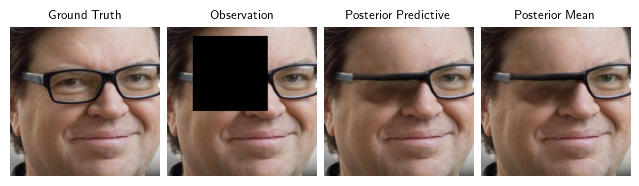

In [14]:
y0 = y.clone()
x0_pred, mu, mu_s, x0_pred_s = red_diff(1000,
                                        x_true,
                                        y0,
                                        device,
                                        model,
                                        custom_physics,
                                        save_evolutions=True)

# plot the results
plot([x, y0, x0_pred, mu], 
     titles=["Ground Truth", "Observation", "Posterior Predictive", "Posterior Mean"])